In [1]:
# baseline cnn model for mnist
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

In [2]:
def load_dataset():
    """load train and test dataset
    """
    # load dataset
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # reshape dataset to have a single channel
    x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
    x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))
    
    # one hot encode target values
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_dataset()

print(x_train.shape)
print(x_train[0,10,:,:])

(60000, 28, 28, 1)
[[  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [ 14]
 [  1]
 [154]
 [253]
 [ 90]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]]


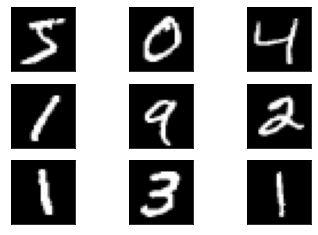

In [15]:
fig, axs = plt.subplots(3,3)
axs = axs.ravel()
for i in range(9):
	ax = axs[i]
	ax.imshow(x_train[i], cmap=plt.get_cmap('gray'))

	# Turn off tick labels
	ax.set_yticklabels([])
	ax.set_xticklabels([])
 
 	#remove the tick marks
	ax.set_xticks([])
	ax.set_yticks([])
 
plt.show()

In [16]:
# scale pixels
def prep_pixels(train, test):
    """
    """
    
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0

    return train_norm, test_norm

x_train,x_test = prep_pixels(x_train,x_test)

# verify sample 0 row 10
print(x_train[0,10,:,:])

[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.05490196]
 [0.00392157]
 [0.6039216 ]
 [0.99215686]
 [0.3529412 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]


# Create Convolutional Neural Network

In [17]:
def define_model():
    """Convolutional NN model creation
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
	
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


def evaluate_model(dataX, dataY, n_folds=5):
    """Evaluate a model using k-fold cross-validation
    """
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))

        # stores scores
        scores.append(acc)
        histories.append(history)
        
    return scores, histories

In [18]:
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    X_train, y_train, X_test, y_test = load_dataset()
    
    # prepare pixel data
    X_train, X_test = prep_pixels(X_train, x_test)
    
    # evaluate model
    scores, histories = evaluate_model(X_train, y_train)
    
    return scores, histories 


# entry point, run the test harness
scores, histories = run_test_harness()

> 98.483
> 98.650
> 98.467
> 98.825
> 98.775


In [24]:
def summarize_diagnostics(histories):
    """
    """
    fig,axs = plt.subplots(2,1,figsize=(20,10))
    ax1=axs[0]
    ax2=axs[1]
    for i in range(len(histories)):
        
        ax1.set_title('Cross Entropy Loss',fontsize=16)
        ax1.plot(histories[i].history['loss'], color='r', ls='--',label='train')
        ax1.plot(histories[i].history['val_loss'], color='orange', label='test')
        ax1.grid(alpha=0.3)
        
        # plot accuracy
        ax2.set_title('Classification Accuracy',fontsize=16)
        ax2.plot(histories[i].history['accuracy'], color='green',ls='--', label='train')
        ax2.plot(histories[i].history['val_accuracy'], color='lightgreen', label='test')
        ax2.grid(alpha=0.3)
        
    plt.show()


def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()


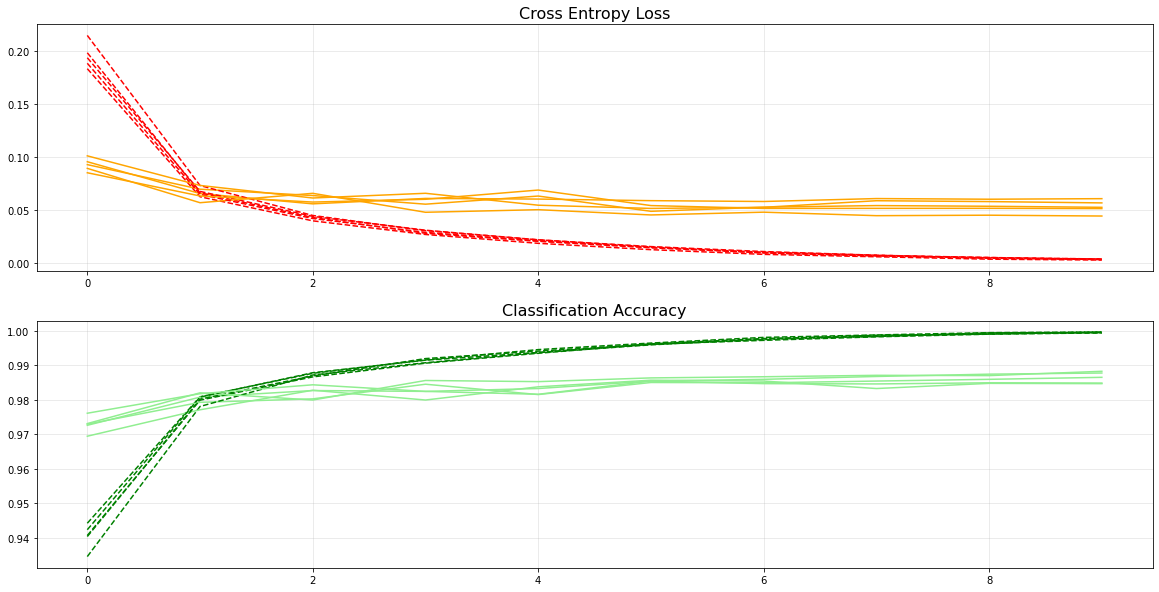

Accuracy: mean=98.640 std=0.146, n=5


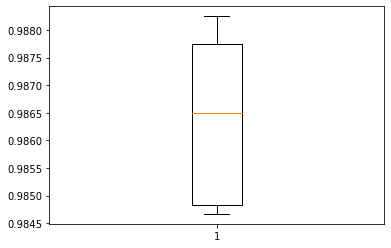

In [25]:
# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)

In [29]:

from keras.layers import BatchNormalization

def define_model():
    """Define Convolutional Neural Network
    Add regualization layer: BatchNormalization
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

> 98.750
> 98.608
> 98.692
> 98.800
> 98.575


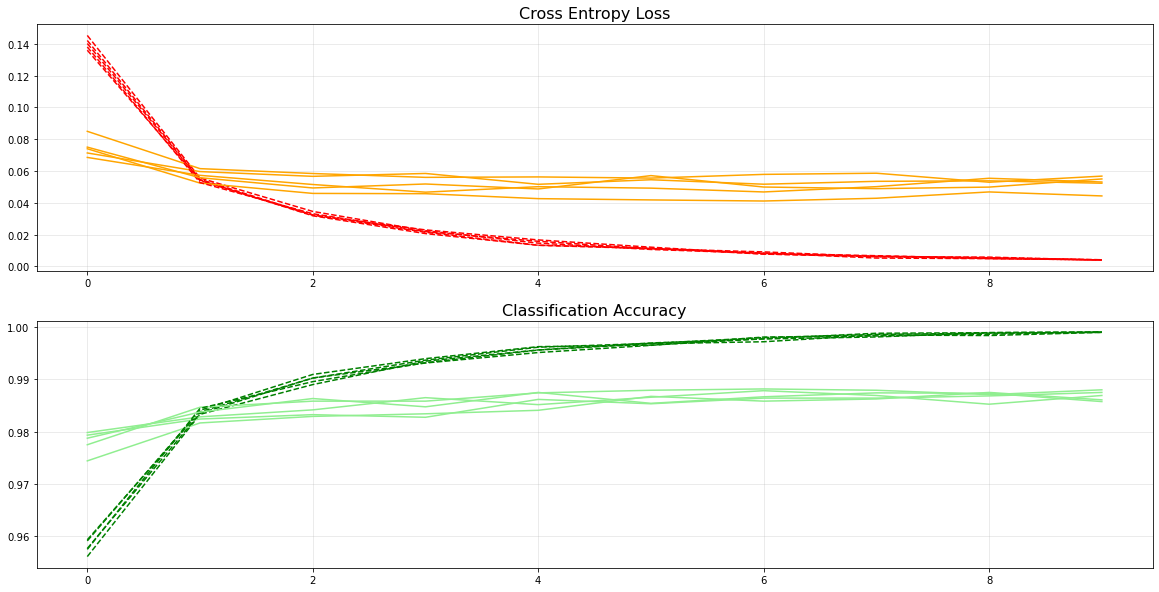

Accuracy: mean=98.685 std=0.084, n=5


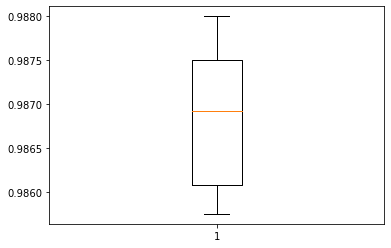

In [30]:
def run_test_harness():
    """
    """
    # load dataset
    X_train, y_train, X_test, y_test = load_dataset()
    
    # prepare pixel data
    X_train, X_test = prep_pixels(X_train, x_test)
    
    # evaluate model
    scores, histories = evaluate_model(X_train, y_train)
    
    return scores, histories 

# entry point, run the test harness
scores, histories = run_test_harness()
# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)

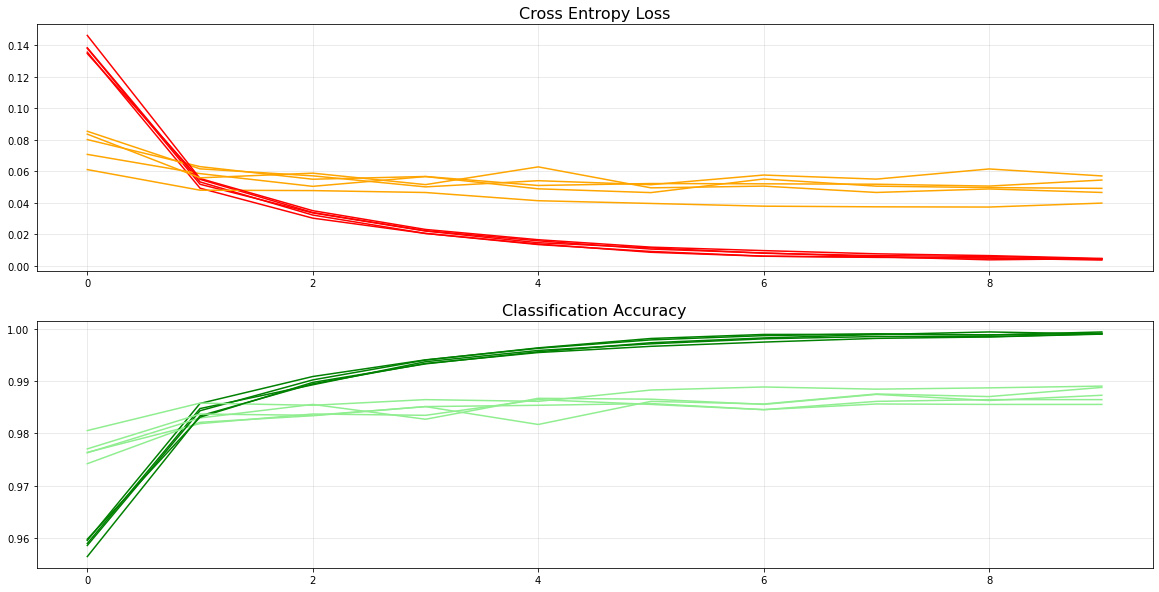

Accuracy: mean=98.738 std=0.134, n=5


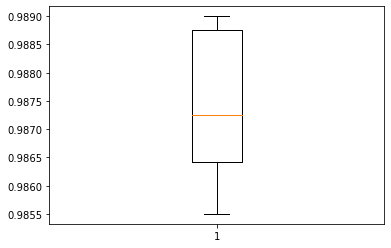

In [31]:
def define_model():
    """ CNN
    3 Convolutional layers
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

> 99.025
> 98.950
> 99.092
> 99.192
> 99.075


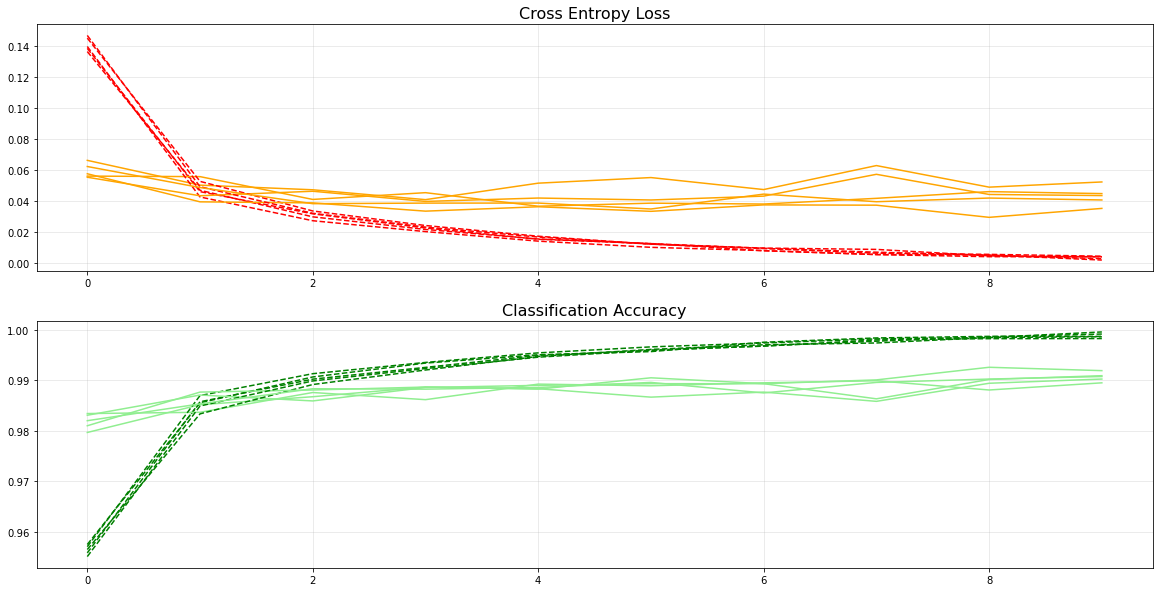

Accuracy: mean=99.067 std=0.080, n=5


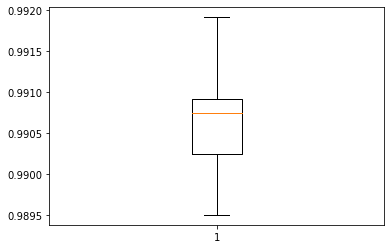

In [32]:
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    X_train, y_train, X_test, y_test = load_dataset()
    
    # prepare pixel data
    X_train, X_test = prep_pixels(X_train, x_test)
    
    # evaluate model
    scores, histories = evaluate_model(X_train, y_train)
    
    return scores, histories 


# entry point, run the test harness
scores, histories = run_test_harness()
# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)